### Imports and configuration

In [65]:
%matplotlib inline

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio

from sklearn.metrics import mean_squared_error

matplotlib.rc('figure', dpi=125)

### Helper functions for data cleaning and analysis

In [54]:
# remove infinite values generated from dividing by 0
def filter_inf(series):
    series = series[series != np.inf]
    return series

# get xy coords from geopandas dataframe in a given crs
def get_points(gpd_df, dest_crs):
    pts = gpd_df.to_crs(dest_crs).geometry
    coords = [(pt.xy[0][0], pt.xy[1][0]) for pt in pts]
    return coords

# sample rasterio dataset with xy coords
def sample_rio_ds(rio_ds, coords):
    sampled_vals = np.array([x[0] for x in rio_ds.sample(coords)])
    # clean bad values from unfiltered DEM
    sampled_vals[sampled_vals < 0] = 0
    sampled_vals[sampled_vals > 3.4e+38] = np.nan
    return sampled_vals

def ft_to_m(series):
    return series * 0.3048

def percent_bias(predicted, observed):
    return 100*((predicted - observed) / observed)

### Open and store rasters

In [55]:
compound_inun = rio.open('data_github/compound_inun_SEP14_alpha1.tif','r')
riv_inun = rio.open('data_github/030202_201809140600_depth_map_projUTM18n.tif','r')
surge_inun = rio.open('data_github/florence_surge_nhc_max.tif','r')
dem = rio.open('data_github/nc_roi_huc6.tif')

rasters = [compound_inun,riv_inun,surge_inun,dem]

### Read points from shapefiles

In [56]:
# EPSG:26918 is UTM Zone 18N for North Carolina

# riverine high water marks
val_riv = gpd.read_file('data_github/shp/HWM.shp')
val_riv.index = range(len(val_riv))
coords_utm_riv = get_points(val_riv, 'epsg:26918') 

# surge peak water levels
val_surge = gpd.read_file('data_github/shp/Peak_water_level.shp')
val_surge.index = range(len(val_surge))
coords_utm_surge = get_points(val_surge, 'epsg:26918')

### Sample rasters at every point location and store values in geopandas dataframes

In [57]:
# sample rasters at riverine HWM shapefile points
val_riv['compound_inun_m_surf'] = sample_rio_ds(compound_inun, coords_utm_riv)
val_riv['riv_inun_m_surf'] = sample_rio_ds(riv_inun, coords_utm_riv)
val_riv['surge_inun_m_surf'] = sample_rio_ds(surge_inun, coords_utm_riv)
val_riv['dem'] = sample_rio_ds(dem, coords_utm_riv)

# add surface elevation to obtain height above NAVD88
val_riv['compound_inun_m_navd88'] = val_riv['compound_inun_m_surf'] + val_riv['dem']
val_riv['riv_inun_m_navd88'] = val_riv['riv_inun_m_surf'] + val_riv['dem']
val_riv['surge_inun_m_navd88'] = val_riv['surge_inun_m_surf'] + val_riv['dem']

# sample rasters at surge PWL shapefile points
val_surge['compound_inun_m_surf'] = sample_rio_ds(compound_inun, coords_utm_surge)
val_surge['riv_inun_m_surf'] = sample_rio_ds(riv_inun, coords_utm_surge)
val_surge['surge_inun_m_surf'] = sample_rio_ds(surge_inun, coords_utm_surge)
val_surge['dem'] = sample_rio_ds(dem, coords_utm_surge)

# add surface elevation to obtain height above NAVD88
val_surge['compound_inun_m_navd88'] = val_surge['compound_inun_m_surf'] + val_surge['dem']
val_surge['riv_inun_m_navd88'] = val_surge['riv_inun_m_surf'] + val_surge['dem']
val_surge['surge_inun_m_navd88'] = val_surge['surge_inun_m_surf'] + val_surge['dem']

### Root mean squared error

In [69]:
rmse_hwm_compound = mean_squared_error(
    val_riv['hwm_m_above_navd88'],
    val_riv['compound_inun_m_navd88'],
    squared=False)
rmse_hwm_riv = mean_squared_error(
    val_riv['hwm_m_above_navd88'],
    val_riv['riv_inun_m_navd88'],
    squared=False)
rmse_hwm_surge = mean_squared_error(
    val_riv['hwm_m_above_navd88'],
    val_riv['surge_inun_m_navd88'],
    squared=False) 

rmse_pwl_compound = mean_squared_error(
    val_surge['pwl_m_above_navd88'],
    val_surge['compound_inun_m_navd88'],
    squared=False) 
rmse_pwl_riv = mean_squared_error(
    val_surge['pwl_m_above_navd88'],
    val_surge['riv_inun_m_navd88'],
    squared=False) 
rmse_pwl_surge = mean_squared_error(
    val_surge['pwl_m_above_navd88'],
    val_surge['surge_inun_m_navd88'],
    squared=False)

print()
print(f'HWM--Compound RMSE:\t{rmse_hwm_compound}')
print(f'HWM--Riverine RMSE:\t{rmse_hwm_riv}')
print(f'HWM--Surge RMSE:\t{rmse_hwm_surge}')
print()
print(f'PWL--Compound RMSE:\t{rmse_pwl_compound}')
print(f'PWL--Riverine RMSE:\t{rmse_pwl_riv}')
print(f'PWL--Surge RMSE:\t{rmse_pwl_surge}')


HWM--Compound RMSE:	3.762117211598319
HWM--Riverine RMSE:	3.79561006739428
HWM--Surge RMSE:	3.7714479972947466

PWL--Compound RMSE:	0.5931122079576746
PWL--Riverine RMSE:	2.354786447311892
PWL--Surge RMSE:	0.5931122079576746


### Percent bias calculation at validation points

In [58]:
## riverine
# convert ft to m
val_riv['hwm_m_above_navd88'] = ft_to_m(val_riv['elev_ft'])
# calculate percent bias
val_riv['hwm_compound_PB_navd88'] = percent_bias(val_riv['compound_inun_m_navd88'], val_riv['hwm_m_above_navd88']) 
val_riv['hwm_riv_PB_navd88'] = percent_bias(val_riv['riv_inun_m_navd88'], val_riv['hwm_m_above_navd88']) 
val_riv['hwm_surge_PB_navd88'] = percent_bias(val_riv['surge_inun_m_navd88'], val_riv['hwm_m_above_navd88']) 
# remove infinite values from dividing by 0
val_riv['hwm_compound_PB_navd88'] = filter_inf(val_riv['hwm_compound_PB_navd88'])
val_riv['hwm_riv_PB_navd88'] = filter_inf(val_riv['hwm_riv_PB_navd88'])
val_riv['hwm_surge_PB_navd88'] = filter_inf(val_riv['hwm_surge_PB_navd88'])

## surge
# convert ft to m
val_surge['pwl_m_above_navd88'] = ft_to_m(val_surge['peak_stage'])
# calculate percent bias
val_surge['pwl_compound_PB_navd88'] = percent_bias(val_surge['compound_inun_m_navd88'], val_surge['pwl_m_above_navd88']) 
val_surge['pwl_riv_PB_navd88'] = percent_bias(val_surge['riv_inun_m_navd88'], val_surge['pwl_m_above_navd88']) 
val_surge['pwl_surge_PB_navd88'] = percent_bias(val_surge['surge_inun_m_navd88'], val_surge['pwl_m_above_navd88'])
# remove infinite values from dividing by 0
val_surge['pwl_compound_PB_navd88'] = filter_inf(val_surge['pwl_compound_PB_navd88'])
val_surge['pwl_riv_PB_navd88'] = filter_inf(val_surge['pwl_riv_PB_navd88'])
val_surge['pwl_surge_PB_navd88'] = filter_inf(val_surge['pwl_surge_PB_navd88'])

# ## riverine above surface/terrain rather than NAVD88
# # convert ft to m
# val_riv['hwm_m_above_surf'] = ft_to_m(val_riv['height_abo'])
# # calculate percent bias
# # above surface
# val_riv['hwm_compound_PB_surf'] = percent_bias(val_riv['compound_inun_m_surf'], val_riv['hwm_m_above_surf'])
# val_riv['hwm_riv_PB_surf'] = percent_bias(val_riv['riv_inun_m_surf'], val_riv['hwm_m_above_surf'])
# val_riv['hwm_surge_PB_surf'] = percent_bias(val_riv['surge_inun_m_surf'], val_riv['hwm_m_above_surf'])
# # remove infinite values from dividing by 0
# val_riv['hwm_compound_PB_surf'] = filter_inf(val_riv['hwm_compound_PB_surf'])
# val_riv['hwm_riv_PB_surf'] = filter_inf(val_riv['hwm_riv_PB_surf'])
# val_riv['hwm_surge_PB_surf'] = filter_inf(val_riv['hwm_surge_PB_surf'])

### Box plots

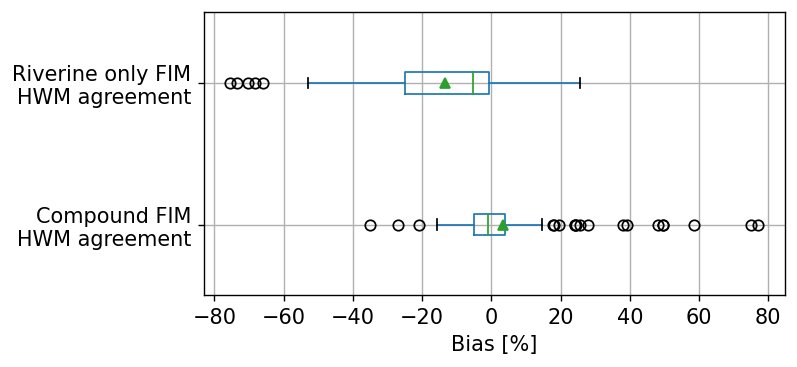

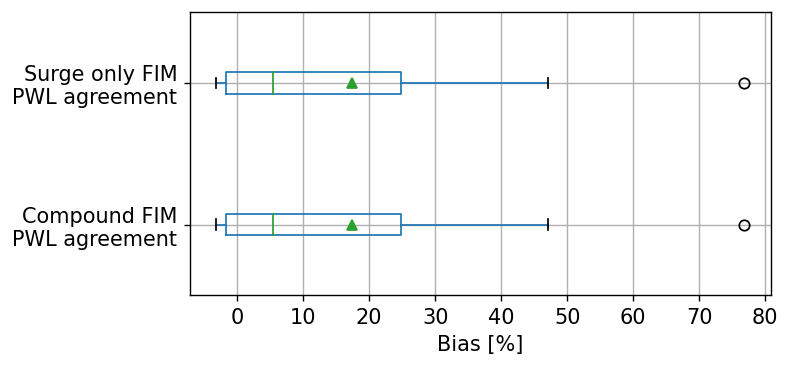

In [70]:
plt.close('all')

fsize = 12

# rename columns for nice plot labels
val_riv_clean_names = val_riv.rename(
    columns={
        'hwm_compound_PB_navd88': 'Compound FIM\nHWM agreement',
        'hwm_riv_PB_navd88': 'Riverine only FIM\nHWM agreement'
        })
val_surge_clean_names = val_surge.rename(
    columns={
        'pwl_compound_PB_navd88': 'Compound FIM\nPWL agreement',
        'pwl_surge_PB_navd88': 'Surge only FIM\nPWL agreement'
        })

# make plots
hwm_bplot = val_riv_clean_names.boxplot(
    column = [
        'Compound FIM\nHWM agreement',
        'Riverine only FIM\nHWM agreement'
    ],
    showmeans = True,
    # showfliers = False,
    vert = False,
    fontsize = fsize,
    figsize=(6,3)
    )
hwm_bplot.set_xlabel('Bias [%]',fontsize=fsize)
# plt.savefig(
#     'data_github/hwm_boxplot.png',
#     bbox_inches="tight",
#     facecolor='w'
#     )
plt.show()

pwl_bplot = val_surge_clean_names.boxplot(
    column = [
        'Compound FIM\nPWL agreement',
        'Surge only FIM\nPWL agreement'
    ],
    showmeans = True,
    # showfliers = False,
    vert = False,
    fontsize = fsize,
    figsize=(6,3)
    )
pwl_bplot.set_xlabel('Bias [%]',fontsize=fsize)
# plt.savefig(
#     'data_github/pwl_boxplot.png',
#     bbox_inches="tight",
#     facecolor='w'
#     )
plt.show()

### Histograms

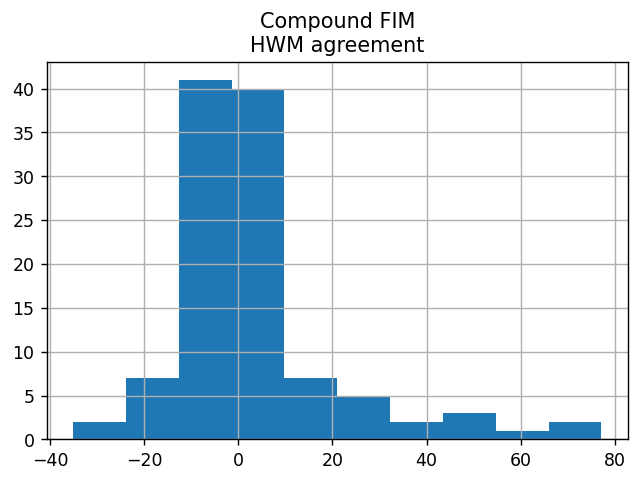

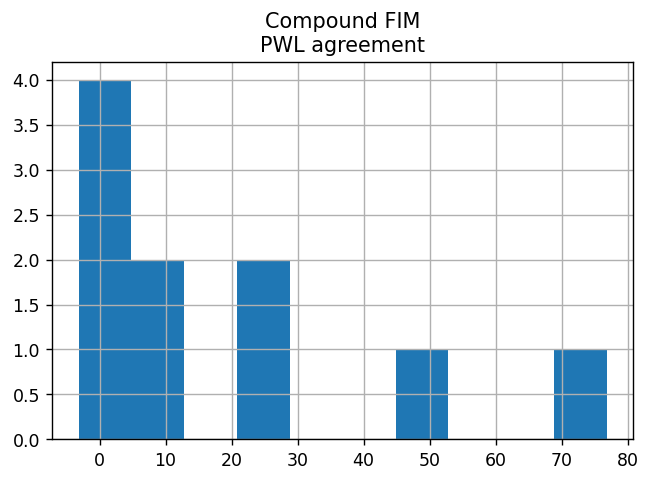

In [60]:
plt.close('all')

val_riv_clean_names.hist(
    column = [
        'Compound FIM\nHWM agreement'
    ],
    )
plt.show()

val_surge_clean_names.hist(
    column = [
        'Compound FIM\nPWL agreement'
    ],
    )
plt.show()

### Close rasterio datasets

In [61]:
[raster.close() for raster in rasters]

[None, None, None, None]